# Project 4: West Nile Virus Prediction
##### Tarin Poddar, Jon Vail, and Connor Foley

For this project, we are predicting whether or not a mosquito trap in Chicago will contain a mosquito infected with West Nile Virus using the *West Nile Virus Prediction* Kaggle competition data.

In [19]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(69)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.cluster import KMeans, k_means
#import xgboost as xgb
from sklearn import svm
from sklearn.utils import resample

### Load the Data

In [20]:
# Load in the combined Weather and Train datasets
train = pd.read_csv('./input/new_train_combine_3.csv')

In [21]:
train.isna().sum().sum()

0

In [22]:
# Load the test dataset
test = pd.read_csv('./input/new_test.csv')

### Explore and Clean the Data
Note: the csv file loaded above was already explored and cleaned substantially, and the process can be found in another notebook if needed. 

In [23]:
train.drop(['Unnamed: 0', 'Unnamed: 0.1', 'index'], axis=1, inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)

In [24]:
mask = train['WnvPresent'] > 1

In [25]:
train['WnvPresent'].loc[mask] = 1

C:\Users\jmvail\Anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [26]:
# Baseline accuracy
train['WnvPresent'].value_counts()[0]/sum(train['WnvPresent'].value_counts())

0.9460766961651917

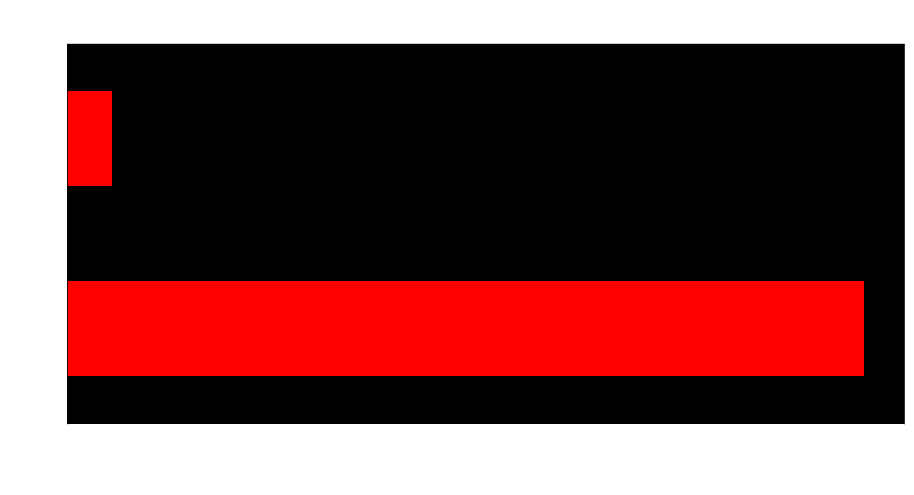

In [100]:
ax = train['WnvPresent'].value_counts().plot(kind='barh', figsize=(15,7),
                                        color="red", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("West Nile", fontsize=40, color = 'white')
ax.set_facecolor('black')
ax.set_xlabel("Number of observations", fontsize=40, color = 'white')
ax.set_ylabel("Present", fontsize=40, color = 'white');

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')


# create a list to collect the plt.patches data
totals = []

# find the values for each author and set it to list
totals = list(train['WnvPresent'].value_counts().values)

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
#for i in ax.patches:
    # for X find the posistion along horizontal axis, For y, find posistion along vertical axis, 
    # calculate percentage, Font size, color
#    ax.text(i.get_width()-3000, i.get_y()+.15, \
#str(round((i.get_width()/total)*100, 2))+'%', fontsize=40)

In [28]:
test.drop('Id', axis=1, inplace=True)

In [29]:
# Set up X and y
y = train.WnvPresent

In [30]:
X = train[[col for col in train.columns if col != 'WnvPresent']]

### Feature Engineering
We combined several features from 2-3 columns into one logical feature so as not clutter our data. We also converted the date from a `str` format to a UTC `datetime` format, which was easily converted to `float`. After scaling, the four distinct time periods were still clearly visible on a plot.

In [31]:
X['Sunlight'] = X['Sunset'] - X['Sunrise']

In [32]:
test['Sunlight'] = test['Sunset'] - test['Sunrise']

In [33]:
X['temp_range'] = X['Tmax'] - X['Tmin']
test['temp_range'] = test['Tmax'] - test['Tmin']

In [34]:
X['Date'] = pd.to_datetime(X['Date'], utc=True)
test['Date'] = pd.to_datetime(test['Date'], utc=True)

In [35]:
def make_date_float(d):
    return d.timestamp()
X['Date'] = [make_date_float(n) for n in X['Date']]
test['Date'] = [make_date_float(n) for n in test['Date']]

In [36]:
# Drop unnecessary or redundant columns
X.drop(['Address','AddressAccuracy', 'Street','AddressNumberAndStreet', 'Block', 'Sunrise','Sunset', 'NumMosquitos', 'Tmax','Tmin'], axis=1, inplace=True)
test.drop(['Address','AddressAccuracy', 'Street','AddressNumberAndStreet', 'Block', 'Sunrise','Sunset', 'Tmax', 'Tmin'], axis=1, inplace=True)

In [37]:
# Turn wind direction into categorical data based on North, East, South, or West
def direction(d):
    if d > 315 or d <= 45:
        x = 'N'
    elif d > 45 and d <= 135:
        x = 'E'
    elif d > 135 and d <= 225:
        x = 'S'
    elif d > 225 and d <= 315:
        x = 'W'
    return x

In [38]:
ResultDir_dum = []
for i in range(len(X['ResultDir'])):
    z = direction(X['ResultDir'][i])
    ResultDir_dum.append(z)
    
X['ResultDir_dum'] = ResultDir_dum

In [39]:
ResultDir_dum2 = []
for i in range(len(test['ResultDir'])):
    z = direction(test['ResultDir'][i])
    ResultDir_dum2.append(z)
    
test['ResultDir_dum'] = ResultDir_dum2

In [40]:
X.drop('ResultDir', axis=1, inplace=True)
test.drop('ResultDir', axis=1, inplace=True)

In [41]:
# Ensure any dummified features that exist in the test set but not the train set do not 
# create dimension problems for our model 
def get_dummied(train, test):
    list = []
    for i in train.columns:
        if train[i].dtype == object:
            list.append(i)
            
    full_data = pd.concat([train, test], axis=0)
    full_data = pd.get_dummies(full_data, columns=list, drop_first=True)
    
    X_dummied = full_data[:len(train)]
    test_dummied = full_data[len(train):]

    return X_dummied, test_dummied 

In [42]:
X, test = get_dummied(X, test)

In [43]:
test.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

---------------------
Here we use K Means Clustering to create categorical geographic zones instead of latitude and longitude values, as those values do not have any meaning for our model and will add noise.

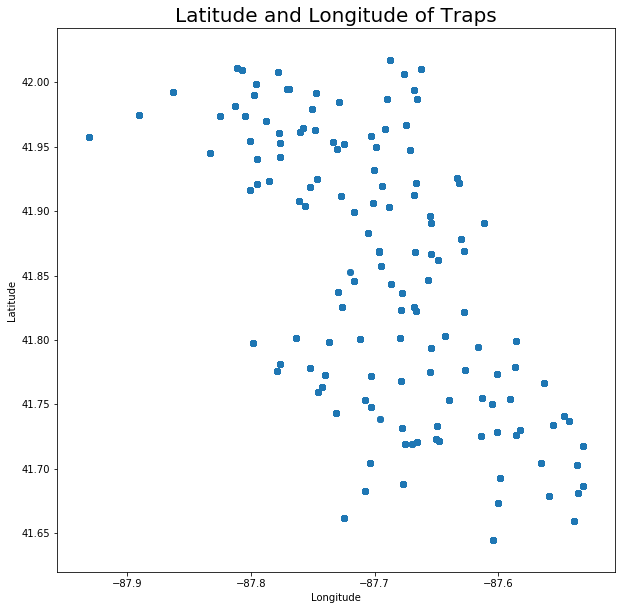

In [44]:
plt.figure(figsize=(10,10))
plt.title("Latitude and Longitude of Traps", fontsize=20)
plt.scatter(X.Longitude, X.Latitude)
plt.xlabel("Longitude")
plt.ylabel("Latitude");

In [45]:
geo = pd.DataFrame()
geo['long']=X.Longitude
geo['lat']=X.Latitude
geo.head(3)

,long,lat
0,-87.800991,41.954690
1,-87.800991,41.954690
2,-87.769279,41.994991


In [46]:
kmeans = KMeans(n_clusters=4)
model = kmeans.fit(geo)
labels = model.labels_

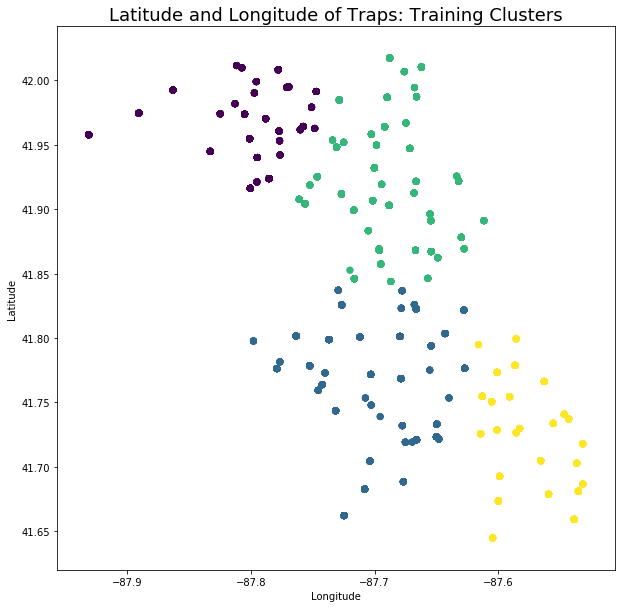

In [47]:
plt.figure(figsize=(10,10))
plt.title("Latitude and Longitude of Traps: Training Clusters", fontsize=18)
plt.scatter(geo.long, geo.lat, c=labels);
plt.xlabel("Longitude")
plt.ylabel("Latitude");

In [48]:
X['geo_zone'] = labels

In [49]:
test_geo = pd.DataFrame()
test_geo['long']=test.Longitude
test_geo['lat']=test.Latitude
test_geo.head(3)

,long,lat
0,-87.800991,41.95469
1,-87.800991,41.95469
2,-87.800991,41.95469


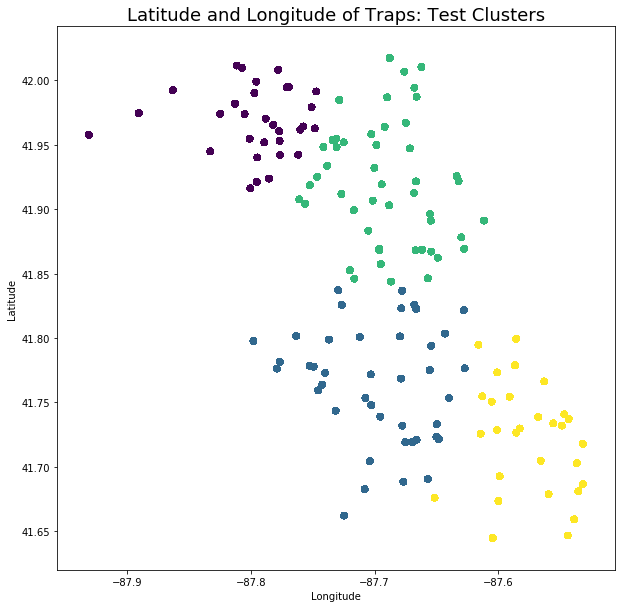

In [50]:
plt.figure(figsize=(10,10))
plt.title("Latitude and Longitude of Traps: Test Clusters", fontsize=18)
plt.scatter(test_geo.long, test_geo.lat, c=model.predict(test_geo));
plt.xlabel("Longitude")
plt.ylabel("Latitude");

In [51]:
test['geo_zone'] = model.predict(test_geo)

In [52]:
X_geo_dums = pd.get_dummies(X.geo_zone)
test_geo_dums = pd.get_dummies(test.geo_zone)

In [53]:
X = pd.concat([X_geo_dums, X], axis=1)

In [54]:
test = pd.concat([test_geo_dums, test], axis=1)

In [55]:
X.drop(['Latitude', 'Longitude', 'geo_zone'], axis=1, inplace=True)
test.drop(['Latitude', 'Longitude', 'geo_zone'], axis=1, inplace=True)

In [56]:
X.head(3)

,0,1,2,3,Date,Tavg,DewPoint,WetBulb,Heat,Cool,...,Trap_T231,Trap_T232,Trap_T233,Trap_T234,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903
0,1,0,0,0,1.180397e+09,75.25,58.5,65.5,0.0,10.5,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1.180397e+09,75.25,58.5,65.5,0.0,10.5,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1.180397e+09,75.25,58.5,65.5,0.0,10.5,...,0,0,0,0,0,0,0,0,0,0


In [57]:
test.head(3)

,0,1,2,3,Date,Tavg,DewPoint,WetBulb,Heat,Cool,...,Trap_T231,Trap_T232,Trap_T233,Trap_T234,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903
0,1,0,0,0,1.213142e+09,75.0,55.5,64.0,0.0,10.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1.213142e+09,75.0,55.5,64.0,0.0,10.0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1.213142e+09,75.0,55.5,64.0,0.0,10.0,...,0,0,0,0,0,0,0,0,0,0


##### Preprocessing: Train test split and StandardScaler

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [59]:
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

### Build the Model(s)

We first wanted to explore using a Balanced Bagging Classifier inside a Pipeline to handle the problem of unbalanced classes. However, this model is very uninterpretable as there is no way to access the feature importances of the Random Forest base estimator. Therefore, we fit a RandomForestClassifier model outside of the BBC model in order to gain some interpretability. 

In [60]:
rfc = RandomForestClassifier(random_state=69)

In [61]:
rf_params = {
    'n_estimators': [10,20,30,35,40,50,100],
    'max_depth': [None, 5, 10, 15],
    'max_features': ['auto', 'log2', 0.25, 0.5, 0.75]  
}

rf_gs = GridSearchCV(rfc, rf_params, scoring='recall')

In [62]:
rf_gs.fit(X_train, y_train)
print("Training data:", rf_gs.score(X_train, y_train))
print("Test data:", rf_gs.score(X_test, y_test))

Training data: 0.9708454810495627
Test data: 0.09649122807017543


In [63]:
rf_gs.best_params_ # Use these in BBC Base Estimator

{'max_depth': None, 'max_features': 0.75, 'n_estimators': 50}

In [64]:
rf_preds = rf_gs.predict(test)

In [65]:
set(rf_preds)

{0}

In [66]:
rfc_feats = rf_gs.best_estimator_.feature_importances_

In [67]:
rfc_feats_df = pd.DataFrame(list(zip(X.columns.values, np.abs(rfc_feats))), columns=['feature','coef_abs'])

In [68]:
rfc_feats_df.sort_values('coef_abs', ascending=False, inplace=True)

In [69]:
rfc_feats_df.head(10).to_csv('./top_rf_feats.csv')

---------------------------------

In [70]:
rf = RandomForestClassifier(n_estimators=50, max_features=0.75, max_depth=None, random_state=69)

In [71]:
bbc = BalancedBaggingClassifier(base_estimator=rf, random_state=69)

In [72]:
bbc.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.75, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=69, verbose=0, warm_start=False),
             bootstrap=True, bootstrap_features=False, max_features=1.0,
             max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
             random_state=69, ratio='auto', replacement=False, verbose=0,
             warm_start=False)

In [73]:
yhat = bbc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, yhat))
print("ROC AUC Score:", roc_auc_score(y_test, yhat))
print("Recall Score:", recall_score(y_test, yhat))

Accuracy: 0.7437470504955167
ROC AUC Score: 0.7529006431290195
Recall Score: 0.7631578947368421


In [74]:
confusion_matrix(y_test, yhat)

array([[1489,  516],
       [  27,   87]], dtype=int64)

In [75]:
set(bbc.predict(test))

{0}

________________________

In [76]:
params = {
    'n_estimators': [3,4,5,6],
    'warm_start': [True, False]
    }

gs = GridSearchCV(bbc, params, scoring='recall')

In [77]:
gs.fit(X_train, y_train)
print("Train data:", gs.score(X_train, y_train))
print("Test data:", gs.score(X_test, y_test))

Train data: 0.9504373177842566
Test data: 0.7368421052631579


In [78]:
gs.best_params_

{'n_estimators': 6, 'warm_start': True}

In [79]:
set(gs.predict(test))

{0}

-------------------------------

In [80]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('poly', PolynomialFeatures(interaction_only=True)),
    ('bbc', bbc)
])

In [81]:
parameters = {
#     'bbc__n_estimators': [3, 5],
    'bbc__warm_start': [True]
}

pipe_gs = GridSearchCV(pipe, parameters, scoring='recall')

In [82]:
pipe_gs.fit(X_train, y_train)
print("Training score:", pipe_gs.score(X_train, y_train))
print("Test score:", pipe_gs.score(X_test, y_test))

Training score: 0.967930029154519
Test score: 0.7631578947368421


In [83]:
pipe_gs.best_params_

{'bbc__warm_start': True}

In [84]:
pipe_xtest_preds = pipe_gs.predict(X_test)

In [85]:
confusion_matrix(y_test, pipe_xtest_preds)

array([[1478,  527],
       [  27,   87]], dtype=int64)

In [86]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [87]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [102]:
def plot_confusion_matrix_white(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, color = 'white')
    
    color_bar = plt.colorbar()                            
    plt.setp(plt.getp(color_bar.ax.axes, 'yticklabels'), color='w') 
      
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color='white')
    plt.yticks(tick_marks, classes, color='white')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', color = 'white')
    plt.xlabel('Predicted label', color = 'white')

In [103]:
y_predition = pipe_gs.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_predition)
np.set_printoptions(precision=2)

In [104]:
len(y_predition)

2119

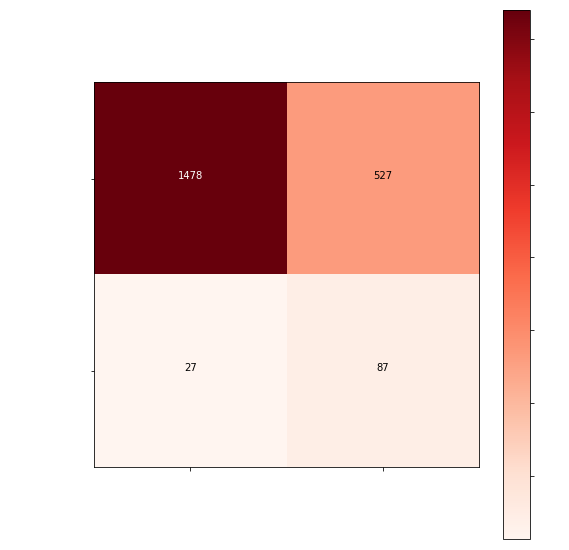

In [105]:
plt.figure(figsize=(8,8))
plot_confusion_matrix_white(cnf_matrix, classes=['Do Not Spary', 'Spray'],
                      title='Confusion Matrix')
plt.show()

In [106]:
y_predition = np.zeros(2119)
cnf_matrix = confusion_matrix(y_test, y_predition)
np.set_printoptions(precision=2)

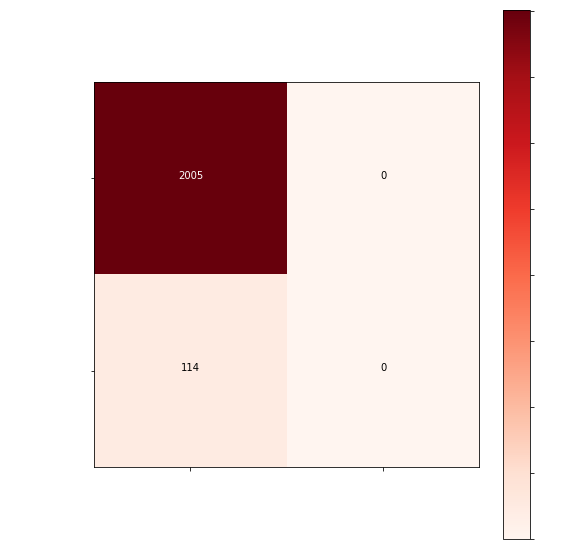

In [108]:
plt.figure(figsize=(8,8))
plot_confusion_matrix_white(cnf_matrix, classes=['Do Not Spary', 'Spray'],
                      title='Confusion Matrix')
plt.show()

In [94]:
pipe_preds = pipe_gs.predict(test)

KeyboardInterrupt: 

In [ ]:
sum(pipe_preds)

In [ ]:
pred2 = pd.DataFrame(pipe_preds , columns=["WnvPresent"])
pred2['Id'] = test2.Id

In [ ]:
pred2 = pred2.set_index('Id')

In [ ]:
pred2.to_csv('./pipe_preds.csv')

##### Other Models
We also tried using an XGB Classifier model and a Support Vector Classifier model. Both of these were encumbured by the problems of unbalanced classes, and gave no useful predictions.

In [ ]:
xg = xgb.XGBClassifier(random_state=69)

In [ ]:
xg_params = {
    'max_depth': [3,6],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [50,100]
}

xg_gs = GridSearchCV(xg, xg_params, scoring='recall')

In [ ]:
xg_gs.fit(X_train, y_train)
print("Training score:", xg_gs.score(X_train, y_train))
print("Test score:", xg_gs.score(X_test, y_test))

In [ ]:
xg_gs.best_params_

In [ ]:
roc_auc_score(y_test, xg_gs.predict(X_test))

In [ ]:
confusion_matrix(y_test, xg_gs.predict(X_test))

-------------------------------

In [ ]:
svc = svm.SVC(random_state=69)

In [ ]:
svc_params = {
    'kernel': ['rbf','linear','poly','sigmoid']
}

svc_gs = GridSearchCV(svc, svc_params, scoring='recall')

In [ ]:
svc_gs.fit(X_train, y_train)

In [ ]:
svc_gs.score(X_test, y_test)

In [ ]:
svc_gs.best_params_

In [ ]:
roc_auc_score(y_test, svc_gs.predict(X_test))

In [ ]:
confusion_matrix(y_test, svc_gs.predict(X_test))

Below we ran a BBC model with `interaction_only=False` in the PolynomialFeatures preprocessing outside of a Pipeline or GridSearch to quickly see how it would perform. It gave us similar predictions to the Pipeline.

In [ ]:
poly = PolynomialFeatures()

Xtr_poly = poly.fit_transform(X_train)
Xte_poly = poly.transform(X_test)

In [ ]:
bbc2 = BalancedBaggingClassifier(base_estimator=RandomForestClassifier(), warm_start=True)

bbc2.fit(Xtr_poly, y_train)

In [ ]:
bbc2pred = bbc2.predict(Xte_poly)

In [ ]:
recall_score(y_test, bbc2pred)

In [ ]:
sum(bbc2pred)

In [ ]:
polytest = poly.transform(test)

In [ ]:
test_preds_bbc = bbc2.predict(polytest)

In [ ]:
test_preds_bbc.sum()/len(test_preds_bbc)

In [ ]:
pred1 = pd.DataFrame(test_preds_bbc , columns=["WnvPresent"])

In [ ]:
test2 = pd.read_csv('./input/new_test.csv')

In [ ]:
pred1['Id'] = test2.Id

In [ ]:
pred1 = pred1.set_index('Id')

In [ ]:
pred1.to_csv('./bbc_preds1.csv')